In [1]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install scikit-learn

You should consider upgrading via the 'c:\users\mrfel\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\mrfel\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\mrfel\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\mrfel\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [1]:
!python --version


Python 3.9.0


In [ ]:
!pip install tensorflow

In [14]:
!pip show matplotlib

Name: matplotlib
Version: 3.10.1
Summary: Python plotting package
Home-page: https://matplotlib.org
Author: John D. Hunter, Michael Droettboom
Author-email: Unknown <matplotlib-users@python.org>
License: License agreement for matplotlib versions 1.3.0 and later

 1. This LICENSE AGREEMENT is between the Matplotlib Development Team
 ("MDT"), and the Individual or Organization ("Licensee") accessing and
 otherwise using matplotlib software in source or binary form and its
 associated documentation.

 2. Subject to the terms and conditions of this License Agreement, MDT
 hereby grants Licensee a nonexclusive, royalty-free, world-wide license
 to reproduce, analyze, test, perform and/or display publicly, prepare
 derivative works, distribute, and otherwise use matplotlib
 alone or in any derivative version, provided, however, that MDT's
 License Agreement and MDT's notice of copyright, i.e., "Copyright (c)
 2012- Matplotlib Development Team; All Rights Reserved" are retained in
 matplotlib

In [9]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report
import tensorflow as tf

ModuleNotFoundError: No module named 'tensorflow'

# Indonesian Rupiah Currency Classification

1. Melakukan set model untuk mengatur lebar, tinggi gambar, epoch dll dengan membuat kelas config

In [ ]:
class Config:
    img_height = 200
    img_width = 200
    epochs = 50
    batch_size = 32
    learning_rate = 1e-3

2. Memanggil directory dataset yang digunakan

In [ ]:
dir_path = 'C:/Users/mrfel/OneDrive/Documents/Code Projects/fake-rupiah-currency-detection-cnn/Uang baru/'
image_paths = []

for dirname, _, filenames in os.walk(dir_path):
    for filename in filenames:
        image_path  = os.path.join(dirname, filename)
        image_paths.append(image_path)

3. Melakukan pengambilan filename dan nominal berdasarkan path yang digunakan



In [ ]:
df = pd.DataFrame({
    'path': image_paths
})

df['filename'] = df.path.apply(lambda x: x.split('/')[5])
df['nominal'] = df.path.apply(lambda x: x.split('/')[-1])
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,path,filename,nominal
0,/content/drive/MyDrive/Uang baru/100000/UANG R...,100000,UANG RUPOAH 100K (117).jpeg
1,/content/drive/MyDrive/Uang baru/100000/UANG R...,100000,UANG RUPOAH 100K (63).jpeg
2,/content/drive/MyDrive/Uang baru/1000/WhatsApp...,1000,WhatsApp Image 2023-04-25 at 11.01.15(2).jpeg
3,/content/drive/MyDrive/Uang baru/1000/WhatsApp...,1000,WhatsApp Image 2023-03-04 at 22.02.14 (2).jpeg
4,/content/drive/MyDrive/Uang baru/1000/WhatsApp...,1000,WhatsApp Image 2023-03-04 at 22.01.54.jpeg


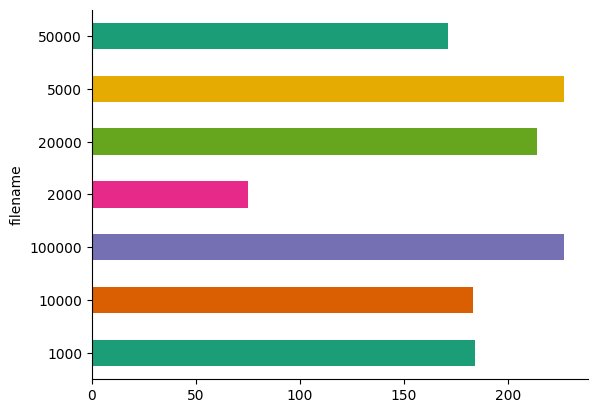

In [ ]:
# @title filename

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('filename').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

4. Melakukan plot pada baru untuk mengecek filename

<BarContainer object of 7 artists>

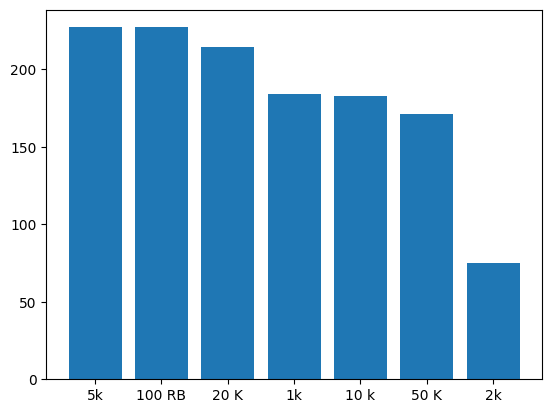

In [ ]:
filename_vc = df.filename.value_counts()
plt.bar(filename_vc.index, filename_vc.values)

5. Memuat dataset gambar untuk pelatihan model TensorFlow dengan melakukan pengaturan subset training, validasi, ukuran gambar, batch size, dan pengacakan data.

In [ ]:
dataset = tf.keras.utils.image_dataset_from_directory(
    dir_path,
    seed=42,
    image_size=(Config.img_height, Config.img_width),
    batch_size=10
)

train_ds = tf.keras.utils.image_dataset_from_directory(
    dir_path,
    subset='training',
    validation_split=0.2,
    seed=42,
    image_size=(Config.img_height, Config.img_width),
    batch_size=Config.batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    dir_path,
    subset='validation',
    validation_split=0.2,
    seed=42,
    image_size=(Config.img_height, Config.img_width),
    batch_size=Config.batch_size
)

Found 1281 files belonging to 7 classes.
Found 1281 files belonging to 7 classes.
Using 1025 files for training.
Found 1281 files belonging to 7 classes.
Using 256 files for validation.


6. Label

In [ ]:
currency_nominal = dataset.class_names
num_of_classes = len(currency_nominal)
currency_nominal

['1000', '10000', '100000', '2000', '20000', '5000', '50000']

7. Menampilkan Gambar dan Label

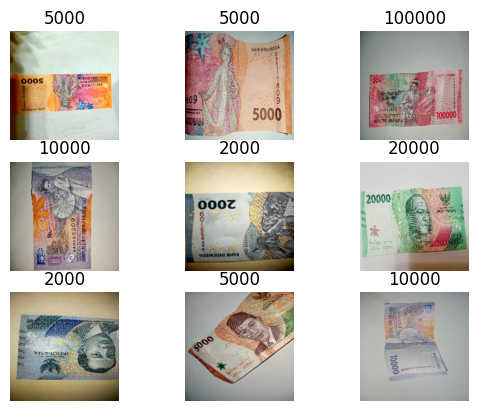

In [ ]:
for images, labels in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(currency_nominal[labels[i]])
        plt.axis('off')

8. Membuat fungsi callback untuk melakukan epoch sebanyak banyaknya sampai accuracy lebih dari 0.90

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
     def on_epoch_end(self, epoch,logs={}):
        if (logs.get("accuracy") > 0.90):
            print("\nStop training, accuracy > 0.90")
            self.model.stop_training = True

callback = myCallback()

9. Menghasilkan variasi data yang lebih banyak dan lebih beragam dari dataset gambar

In [ ]:
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal",
                               input_shape=(
                                   Config.img_height,
                                   Config.img_width,
                                   3)
                              ),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
  ]
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10. Membangun model CNN dengan beberapa layer dan melakuakn pooling serta flatteing

In [ ]:
!pip install keras

In [ ]:
model = tf.keras.Sequential([
    data_augmentation,
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_of_classes)
])

11. Melakukan konfigurasi model seperti optimizer, loss function, dan metrik evaluasi

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=Config.learning_rate),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

12. Melatih model dengan data

In [ ]:
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=Config.epochs,
    callbacks=[callback]
)
model.summary()

Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 380s 11s/step - accuracy: 0.1992 - loss: 1.8883 - val_accuracy: 0.1992 - val_loss: 1.9966
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 298s 9s/step - accuracy: 0.3158 - loss: 1.7150 - val_accuracy: 0.4531 - val_loss: 1.3684
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 331s 9s/step - accuracy: 0.4875 - loss: 1.2830 - val_accuracy: 0.7227 - val_loss: 0.7511
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 288s 9s/step - accuracy: 0.6183 - loss: 1.0468 - val_accuracy: 0.6484 - val_loss: 0.8622
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 334s 9s/step - accuracy: 0.7585 - loss: 0.6831 - val_accuracy: 0.6875 - val_loss: 0.8314
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 313s 9s/step - accuracy: 0.7936 - loss: 0.5289 - val_accuracy: 0.7852 - val_loss: 0.5731
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 351s 9s/step - accuracy: 0.7779 - loss: 0.6582 - val_accuracy: 0.9023 - val_loss: 0.2903
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 321s 10s/step - accuracy: 0.8870 - loss: 0.3334 - val_accuracy: 0.8672 -

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 200, 200, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 200, 200, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 198, 198, 128)       │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 99, 99, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 97, 97, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 46, 46, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 23, 23, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 16928)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       2,166,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,790,967 (25.91 MB)

 Trainable params: 2,263,655 (8.64 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,527,312 (17.27 MB)

13. Melakukan plot pada graph untuk melihat peningkatan accuracy serta loss setiap epoch

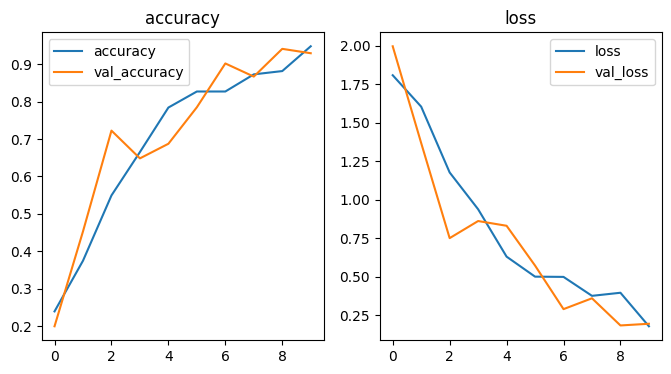

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

ax1.set_title('accuracy')
ax1.plot(model.history.history['accuracy'], label='accuracy')
ax1.plot(model.history.history['val_accuracy'], label='val_accuracy')
ax1.legend()

ax2.set_title('loss')
ax2.plot(model.history.history['loss'], label='loss')
ax2.plot(model.history.history['val_loss'], label='val_loss')
ax2.legend()

In [ ]:
loss, accuracy = model.evaluate(dataset)
print('accuracy :', accuracy)
print('loss     :', loss)

129/129 ━━━━━━━━━━━━━━━━━━━━ 117s 900ms/step - accuracy: 0.9632 - loss: 0.1075
accuracy : 0.9531615972518921
loss     : 0.12782399356365204


Melakukan plot gambar serta label berdasarkan data random yang diambil untuk mengecek apakah model sudah berjalan dengan baik

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


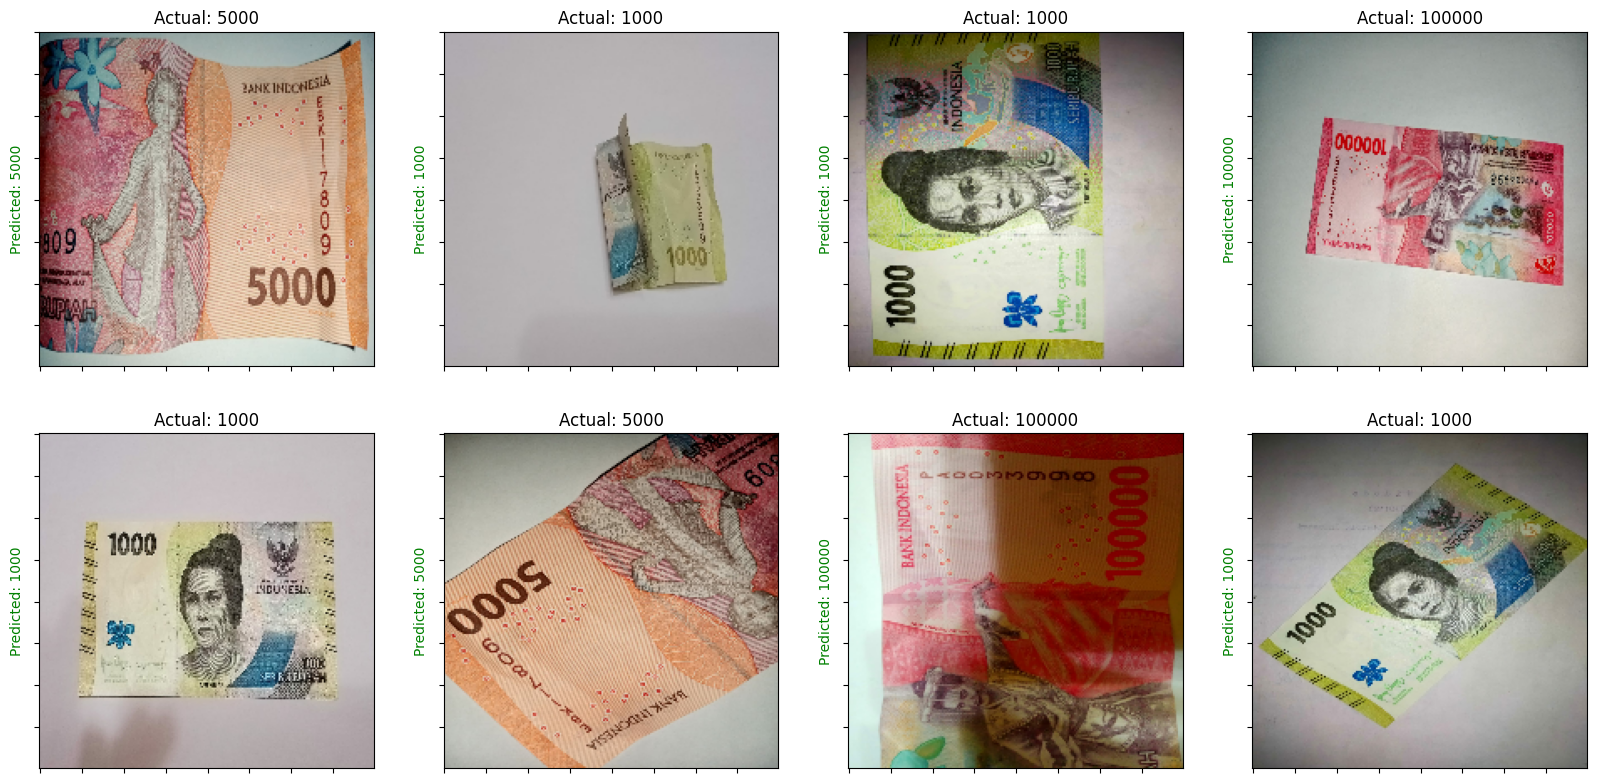

In [ ]:
plt.figure(figsize=(20, 20))
for images, labels in dataset.take(1):
    for i in range(8):
        ax = plt.subplot(4, 4, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        predictions = model.predict(tf.expand_dims(images[i], 0))
        score = tf.nn.softmax(predictions[0])

        predicted_axis_color = 'green' if currency_nominal[labels[i]] == currency_nominal[np.argmax(score)] else 'red'

        plt.title('Actual: ' + currency_nominal[labels[i]])
        plt.ylabel('Predicted: ' + currency_nominal[np.argmax(score)], fontdict={'color': predicted_axis_color})

        plt.gca().axes.xaxis.set_ticklabels([])
        plt.gca().axes.yaxis.set_ticklabels([])

In [ ]:
y_true = []
y_pred = []

for images, labels in val_ds:
    predictions = model.predict(images)
    predicted_labels = tf.argmax(predictions, axis=1)

    y_true.extend(labels.numpy())
    y_pred.extend(predicted_labels.numpy())

# Calculate accuracy (no 'average' parameter needed)
accuracy = accuracy_score(y_true, y_pred)

# Calculate precision, recall, and F1 score (use 'average' here)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Accuracy: 0.9296875
Precision: 0.9345858693677326
Recall: 0.9296875
F1 Score: 0.929914110630063


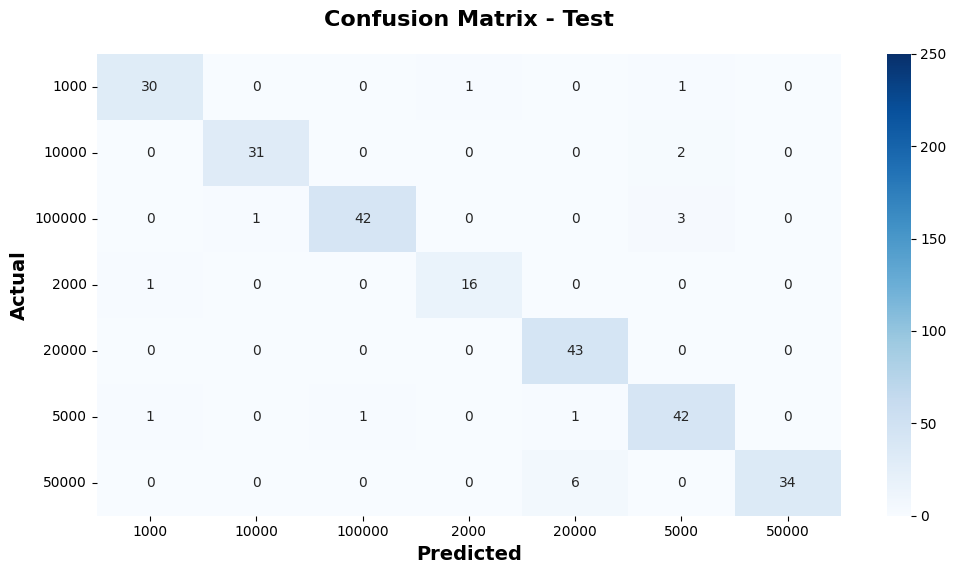

In [ ]:
class_names = ['1000', '10000', '100000', '2000', '20000', '5000', '50000']

CMatrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 6))

# Menampilkan heatmap
ax = sns.heatmap(CMatrix, annot=True, fmt='g', vmin=0, vmax=250, cmap='Blues')

# Set labels untuk sumbu X (Predicted) dan sumbu Y (Actual)
ax.set_xlabel('Predicted', fontdict={'fontsize': 14, 'weight': 'bold'})
ax.set_ylabel('Actual', fontdict={'fontsize': 14, 'weight': 'bold'})

# Menggunakan nominal uang sebagai tick labels
ax.set_xticklabels(class_names, rotation=0)
ax.set_yticklabels(class_names, rotation=0)

# Set title
ax.set_title('Confusion Matrix - Test', fontsize=16, weight='bold', pad=20)

# Tampilkan plot
plt.show()

### Save model

In [ ]:
model.save('my_model.keras')

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Simpan model TensorFlow Lite ke file
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmplc0k33d0'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 200, 200, 3), dtype=tf.float32, name='keras_tensor_4')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  138952397130208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138952397130560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138952397136192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138952397140944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138952397131968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138952397479376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138952397482368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138952397482544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138952397483776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138952395641904: TensorSpec(shape=(), dtype=tf.resource, name=None)
